In [125]:
library(quantmod)
library(ggplot2)
library(tseries)
library(gridExtra)
library(forecast)
library(lmtest)

In [126]:
# Load the US National Home Price data from CSV
HomePrice = read.csv("../US_National_Home_price.csv")

# Format the data to xts
HomePrice = xts(HomePrice, order.by=as.Date(HomePrice$DATE, format="%Y-%m-%d")) 
storage.mode(HomePrice) = "numeric"
HomePrice$DATE = NULL

Warning message in storage.mode(HomePrice) = "numeric":
“NAs introduced by coercion”

In [127]:
# Observe the first few rows of data
head(HomePrice)

           CSUSHPINSA
1987-01-01     63.753
1987-02-01     64.153
1987-03-01     64.490
1987-04-01     64.995
1987-05-01     65.570
1987-06-01     66.238

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.


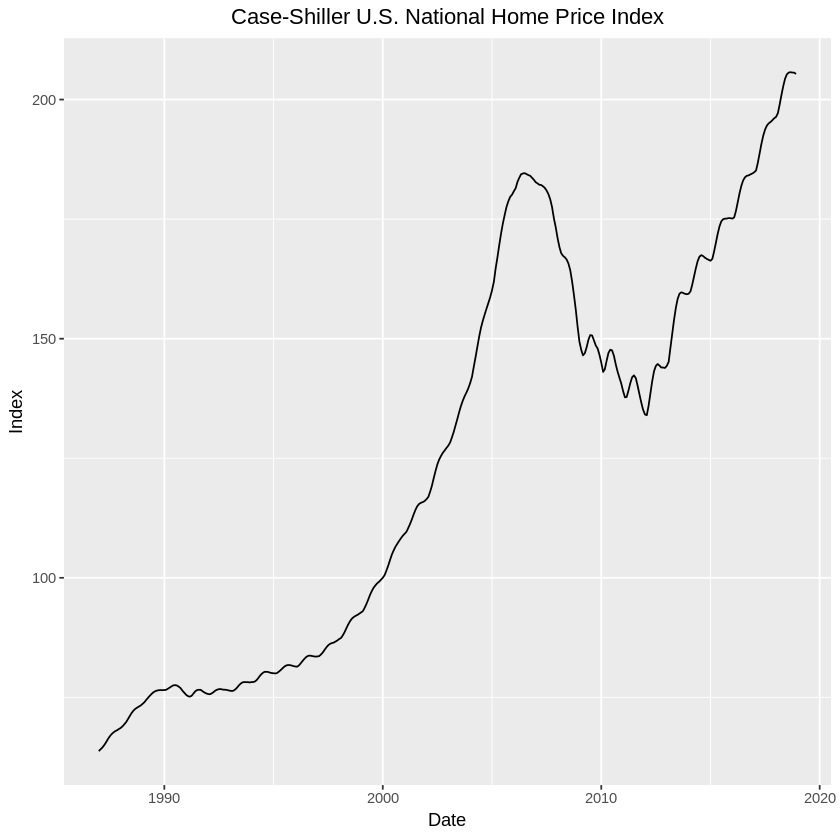

In [128]:
# Plot the price index
ggplot(HomePrice, aes(Index)) + 
    geom_line(aes(y = HomePrice$CSUSHPINSA))+
    ggtitle("Case-Shiller U.S. National Home Price Index") +
    labs(x = "Date", y = "Index") + 
    theme(plot.title = element_text(hjust = 0.5))

## ADF Test

The adf test suggest that the model is non-statitionary. With the p-value at 0.4123, we cannot reject the null hypothesis that an unit root is present.

This suggest for the need to perform differencing

In [129]:
# Perform adf test with time series of HomePrice
# See https://stackoverflow.com/questions/16447461/adf-test-returning-p-0-99-with-xts-but-returning-p-0-01-with-coredataxts

adf.test(as.ts(HomePrice))


	Augmented Dickey-Fuller Test

data:  as.ts(HomePrice)
Dickey-Fuller = -2.3903, Lag order = 7, p-value = 0.4123
alternative hypothesis: stationary


## ACF & PACF Chart

The ACF decays very slowly as the lag increases. This further confirms the need to difference the time series data.

The PACF displays a sharp cut-off at lag 1. This could be identified as an AR signature. 

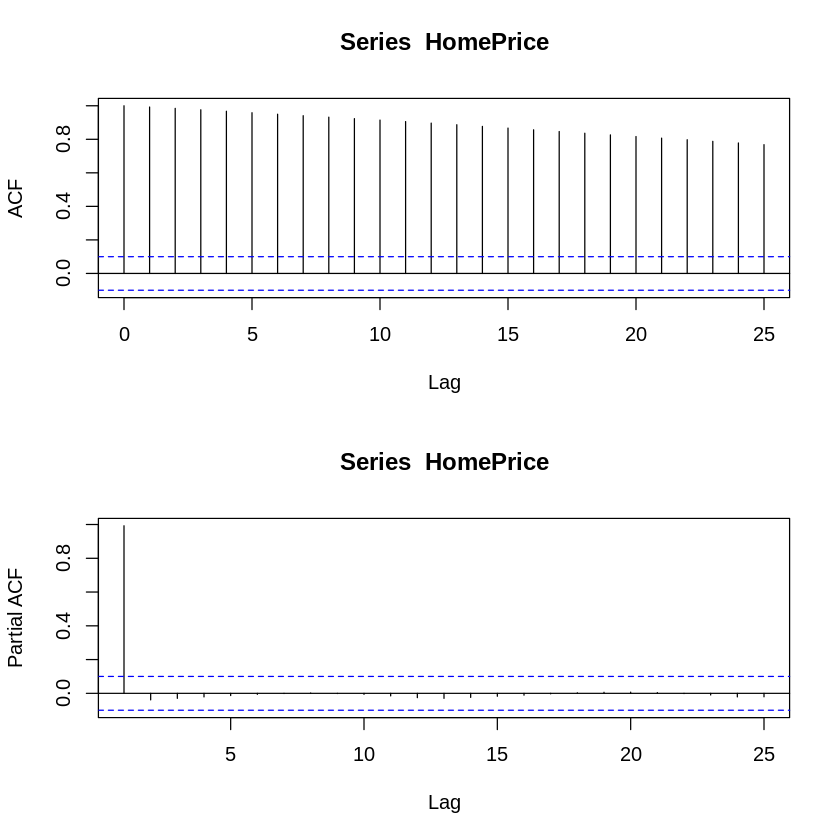

In [130]:
# Plot ACF & PACF for HomePrice

par(mfrow=c(2,1))
acf(HomePrice)
pacf(HomePrice)

## Differencing

### Diff 1

Applying diff 1 to the data, we obtained a p-value of 0.2558 on the ADF test. This suggest that the data is still not stationary at the 1% significance level.

In [131]:
# Applying diff1
diff1 = diff(HomePrice, differences = 1)
diff1 = diff1[2:nrow(diff1)]
adf.test(as.ts(diff1))


	Augmented Dickey-Fuller Test

data:  as.ts(diff1)
Dickey-Fuller = -2.7611, Lag order = 7, p-value = 0.2558
alternative hypothesis: stationary


### Diff 2

Applying diff 2 to the data, we obtained a p-value of 0.01 on the ADF test, suggesting that we can reject the null hypothesis where a unit root is present. 

In [132]:
# Applying diff2
diff2 = diff(HomePrice, differences = 2)
diff2 = diff2[3:nrow(diff2)]
adf.test(as.ts(diff2))

Warning message in adf.test(as.ts(diff2)):
“p-value smaller than printed p-value”


	Augmented Dickey-Fuller Test

data:  as.ts(diff2)
Dickey-Fuller = -15.602, Lag order = 7, p-value = 0.01
alternative hypothesis: stationary


## ACF & PACF of diff(2)

### ACF

The ACF chart for diff(2) shows that there are still significant correlation between the time series that are significantly different from 0 (as observed from the blue dotted lines). 

The sinusiodal graph may suggest the need for AR(2) graph.

However, we can also observe a negative correlation at lag 6 and a strong positive correlation at lag 12. This may suggest a seasonal AR with a period of 12.

### PACF

The PACF chart shows an AR(1) signature where PACF shows a sharp cut-off at the first lag.

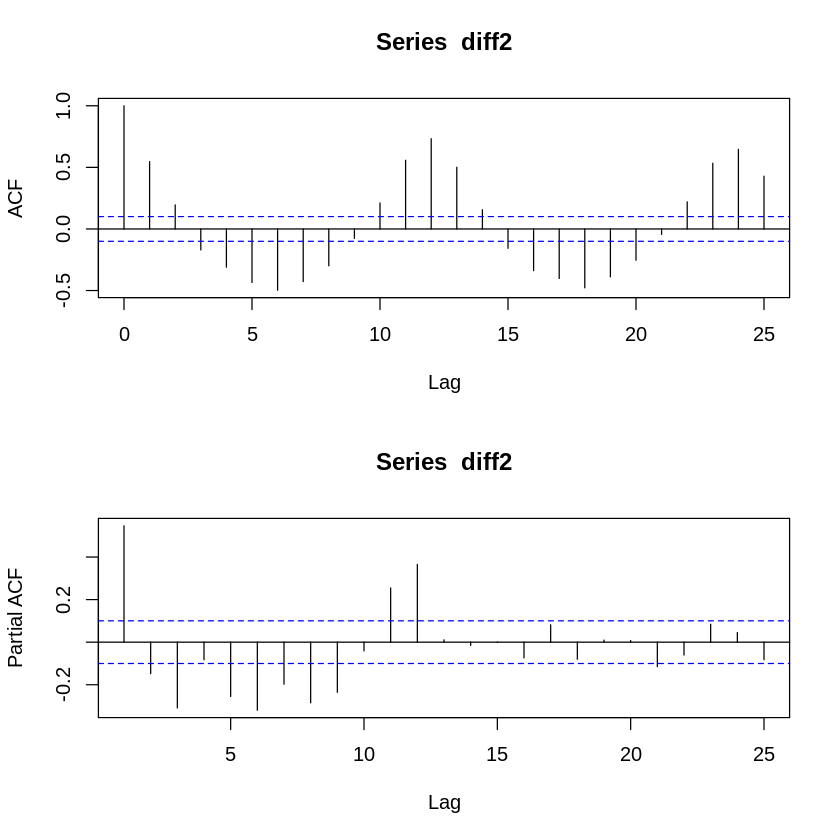

In [133]:
# Plot ACF & PACF for differenced model
# https://stats.stackexchange.com/questions/49571/understanding-the-blue-dotted-lines-in-an-acf-from-r

par(mfrow=c(2,1))
acf(diff2)
pacf(diff2)

## Model 1 - ARIMA(0, 2, 0)


Name | Value
--- | ---
Variance | 0.1703
Log likelihood | -203.9
AIC | 409.79
RMSE | 0.4115899

ACF chart still continues to diplay the sinusoidal wave, peaking at lag 6, 12, 18, 24. This suggest the need for AR(2). 

Ljung-Box-Pierce statistics shows that for all lags, the residuals are not independently distributed.


Call:
arima(x = window(HomePrice), order = c(0, 2, 0), method = "ML")


sigma^2 estimated as 0.1703:  log likelihood = -203.9,  aic = 409.79

Training set error measures:
                       ME      RMSE       MAE         MPE      MAPE      MASE
Training set -0.001927416 0.4115899 0.2602374 0.002485472 0.1939264 0.3497458
                  ACF1
Training set 0.5469119


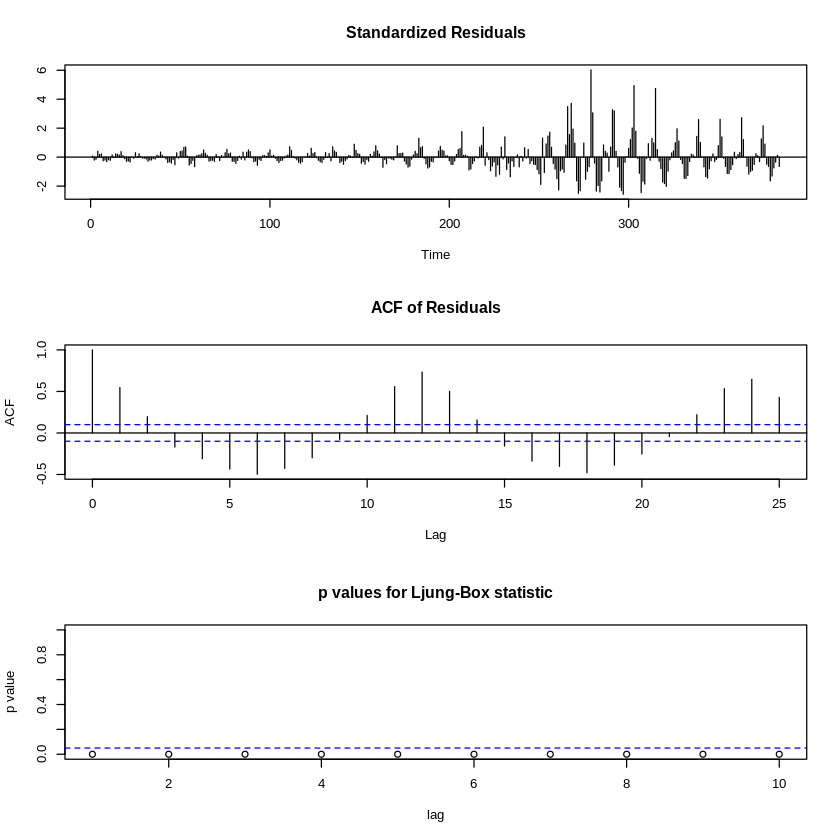

In [134]:
model1 <- arima(window(HomePrice), order=c(0,2,0), method = "ML")

# Print summary of model1
summary(model1)

# Print diagnostics of model1
tsdiag(model1)

## Model 2 - ARIMA(0, 2, 2)

Name | Value
--- | ---
Variance | 0.1101
Log likelihood | -120.87
AIC | 247.73
RMSE | 0.3309369

ACF chart shows smaller spikes compared to model1's. However, it can still be observed that the spiked at 6, 12, 18, 24 is still significant. This suggest that there are correlation that has yet to be accounted for.

Ljung-Box-Pierce statistics shows that for lag 1 to 4, the residuals are independently distributed (white noise), which is good.

Both coefficient, ar1 & ar2, are tested to be significantly different from zero.


Call:
arima(x = window(HomePrice), order = c(0, 2, 2), method = "ML")

Coefficients:
         ma1     ma2
      0.6201  0.4156
s.e.  0.0458  0.0466

sigma^2 estimated as 0.1101:  log likelihood = -120.87,  aic = 247.73

Training set error measures:
                       ME      RMSE       MAE         MPE      MAPE      MASE
Training set -0.001339956 0.3309369 0.2003839 0.001235961 0.1496965 0.2693058
                    ACF1
Training set 0.001531978



z test of coefficients:

    Estimate Std. Error z value  Pr(>|z|)    
ma1 0.620150   0.045808 13.5379 < 2.2e-16 ***
ma2 0.415642   0.046551  8.9288 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


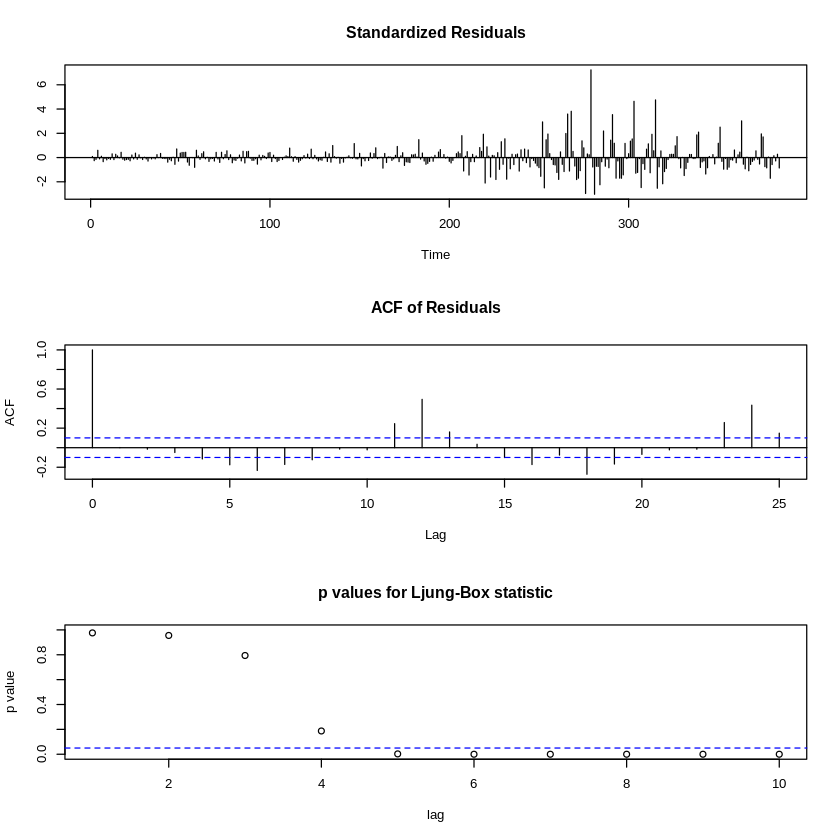

In [135]:
model2 <- arima(window(HomePrice), order=c(0,2,2), method = "ML")

# Print summary of model2
summary(model2)

# Coefficient test of ar1 and ar2
coeftest(model2)

# Print diagnostics of model2
tsdiag(model2)

## Model 3 - ARIMA(2, 2, 0)

Name | Value
--- | ---
Variance | 0.1166
Log likelihood | -131.82
AIC | 269.64
RMSE | 0.3406494

ACF chart shows smaller spikes compared to model1's. However, it can still be observed that the spiked at 6, 12, 18, 24 is still significant. This suggest that there are correlation that has yet to be accounted for.

Ljung-Box-Pierce statistics shows that for all lags, except lag 1, the residuals are not independently distributed.


Both coefficient, ar1 & ar2, are tested to be significantly different from zero.

Overall, model3 outperforms model1 and model2 and should be chosen for non-seasonal arima model. 


Call:
arima(x = window(HomePrice), order = c(2, 2, 0), method = "ML")

Coefficients:
         ar1      ar2
      0.6277  -0.1485
s.e.  0.0506   0.0505

sigma^2 estimated as 0.1166:  log likelihood = -131.82,  aic = 269.64

Training set error measures:
                      ME      RMSE       MAE         MPE      MAPE      MASE
Training set -0.00141818 0.3406494 0.2080001 0.001291073 0.1556069 0.2795416
                    ACF1
Training set -0.04423696



z test of coefficients:

     Estimate Std. Error z value  Pr(>|z|)    
ar1  0.627713   0.050562 12.4146 < 2.2e-16 ***
ar2 -0.148481   0.050537 -2.9381  0.003302 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


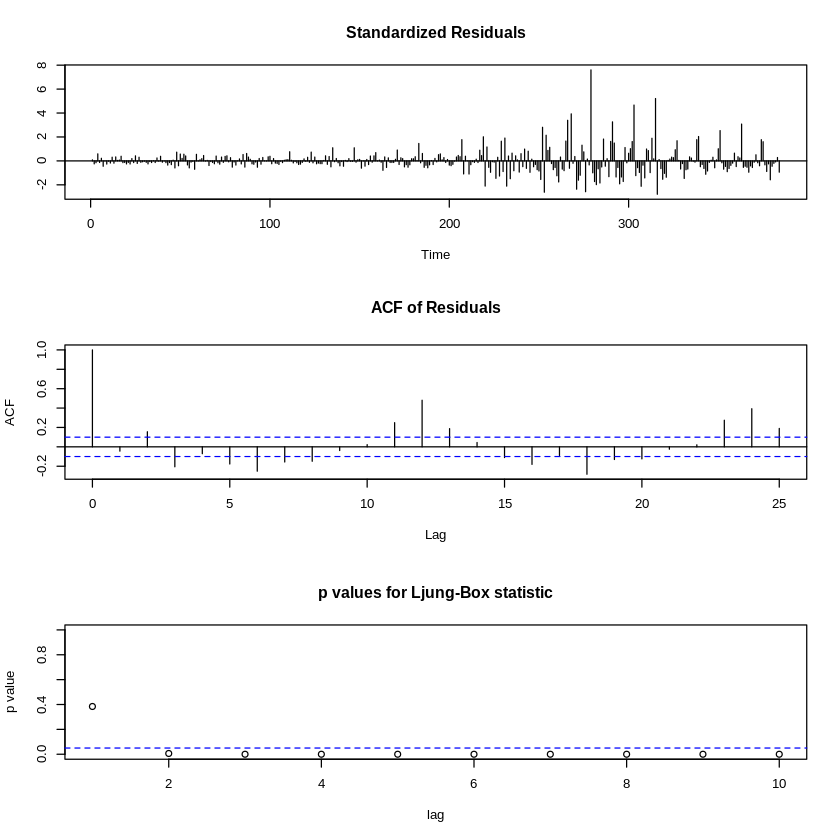

In [136]:
model3 <- arima(window(HomePrice), order=c(2,2,0), method = "ML")

# Print summary of model3
summary(model3)

# Coefficient test of ma1 and ma2
coeftest(model3)

# Print diagnostics of model3
tsdiag(model3)

## Seasonal ARIMA

As suggested by the high positive correlation at lag 12, it is highly possible that the model would be seasonal with period 12. This is further confirmed by the unexplained spiked of ACF for the non-seasonal model at lags of 6, 12, 18 and 24.

## Model 4 - ARIMA (0,2,0) (2,0,0) 12

Name | Value
--- | ---
Variance | 0.07037
Log likelihood | -40.53
AIC | 87.07
RMSE | 0.2646128

ACF chart shows smaller spikes compared to model3's. However, there are still significant spikes at lag 3, 7, 11, 16, 23.

Ljung-Box-Pierce statistics shows that for all lags, the residuals are not independently distributed.


Both coefficient, sar1 & sar2, are tested to be significantly different from zero.


Call:
arima(x = window(HomePrice), order = c(0, 2, 0), seasonal = list(order = c(2, 
    0, 0), period = 12), method = "ML")

Coefficients:
        sar1    sar2
      0.5472  0.2536
s.e.  0.0485  0.0491

sigma^2 estimated as 0.07037:  log likelihood = -40.53,  aic = 87.07

Training set error measures:
                       ME      RMSE       MAE          MPE      MAPE      MASE
Training set -0.001702845 0.2646128 0.1577538 0.0009116675 0.1194314 0.2120131
                  ACF1
Training set 0.1308832



z test of coefficients:

     Estimate Std. Error z value  Pr(>|z|)    
sar1 0.547214   0.048479 11.2877 < 2.2e-16 ***
sar2 0.253567   0.049080  5.1665 2.386e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


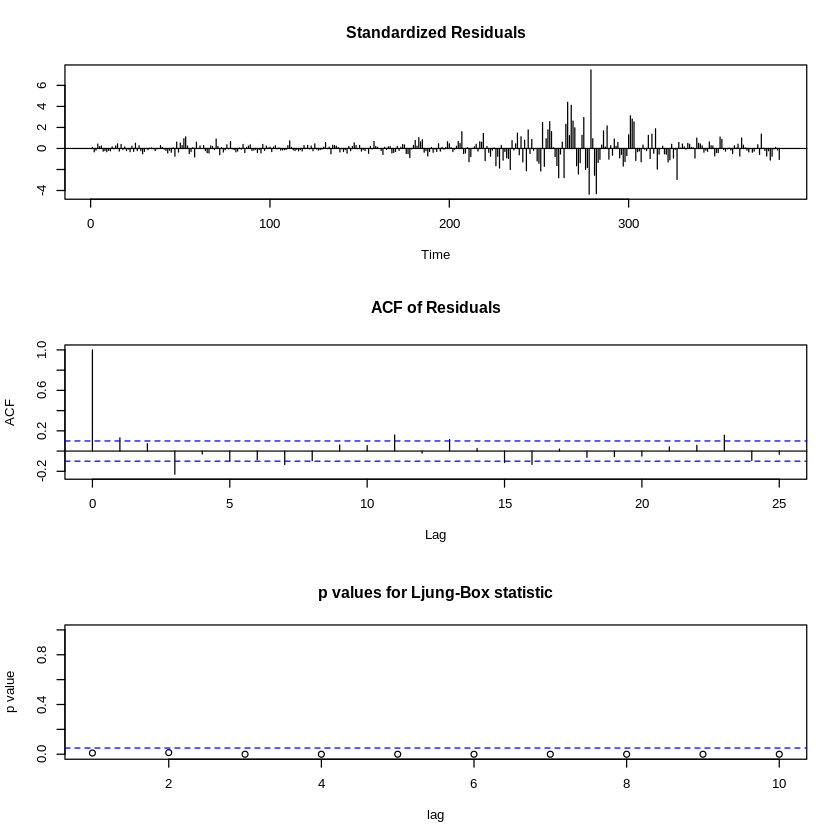

In [137]:
model4 <- arima(window(HomePrice), order=c(0,2,0), seasonal=list(order=c(2,0,0),period=12),  method = "ML")
# Print summary of model4
summary(model4)

# Coefficient test of sar1 and sar2
coeftest(model4)

# Print diagnostics of model4
tsdiag(model4)

## Model 5 - ARIMA (0,2,0) (0,0,2) 12

Name | Value
--- | ---
Variance | 0.09245
Log likelihood | -90.1
AIC | 186.19
RMSE | 0.30329

ACF chart showed similar sinusoidal wave as the model1-3, with smaller ACF spikes on lag 12 and 24. The ACF spikes does not seemed to smoothened around those periods and the ACF spikes on lag 6 and 18 were not affected. This suggest that adding order to the SMA term does not futher explain the prices.

Ljung-Box-Pierce statistics shows that for all lags, the residuals are not independently distributed.

Both coefficient, sar1 & sar2, are tested to be significantly different from zero.


Call:
arima(x = window(HomePrice), order = c(0, 2, 0), seasonal = list(order = c(0, 
    0, 2), period = 12), method = "ML")

Coefficients:
        sma1    sma2
      0.6074  0.3406
s.e.  0.0505  0.0398

sigma^2 estimated as 0.09245:  log likelihood = -90.1,  aic = 186.19

Training set error measures:
                       ME      RMSE       MAE         MPE      MAPE      MASE
Training set -0.001886846 0.3032905 0.1936652 0.001145485 0.1454877 0.2602762
                  ACF1
Training set 0.2722617



z test of coefficients:

     Estimate Std. Error z value  Pr(>|z|)    
sma1 0.607432   0.050532 12.0208 < 2.2e-16 ***
sma2 0.340587   0.039833  8.5504 < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


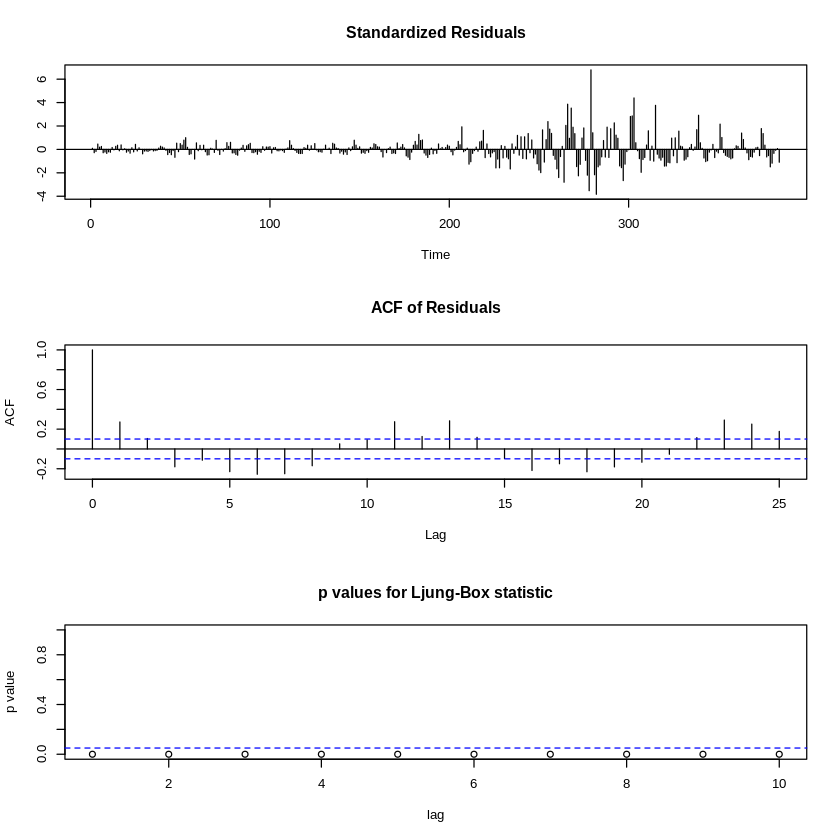

In [138]:
model5 <- arima(window(HomePrice), order=c(0,2,0), seasonal=list(order=c(0,0,2),period=12),  method = "ML")
# Print summary of model5
summary(model5)

# Coefficient test of sma1 and sma2
coeftest(model5)

# Print diagnostics of model5
tsdiag(model5)

## Model 6 - ARIMA (0,2,2) (1,0,1) 12

Following the success of the ARIMA(0,2,2) model, we explore the (0,2,2)(1,0,1)12 model.

Name | Value
--- | ---
Variance | 0.06503
Log likelihood | -25.19
AIC | 60.39
RMSE | 0.2543877

ACF chart showed similar sinusoidal wave as the model1-3, without ACF spikes on lag 6, 12, 18. 24. However, some spikes are observed at 3, 11, 15, 16.

Ljung-Box-Pierce statistics shows that for lag 1 and 2, the residuals are independently distributed (white noise), which is good. 

All coefficients, ma1, ma2, sar1 and sma2, are tested to be significantly different from zero.


Call:
arima(x = window(HomePrice), order = c(0, 2, 2), seasonal = list(order = c(1, 
    0, 1), period = 12), method = "ML")

Coefficients:
         ma1     ma2    sar1     sma1
      0.2622  0.2028  0.9274  -0.5742
s.e.  0.0617  0.0592  0.0274   0.0746

sigma^2 estimated as 0.06503:  log likelihood = -25.19,  aic = 60.39

Training set error measures:
                        ME      RMSE       MAE        MPE      MAPE      MASE
Training set -0.0009910676 0.2543877 0.1454871 0.00120389 0.1104111 0.1955272
                   ACF1
Training set -0.0400247



z test of coefficients:

      Estimate Std. Error z value  Pr(>|z|)    
ma1   0.262224   0.061718  4.2488 2.149e-05 ***
ma2   0.202795   0.059208  3.4252 0.0006145 ***
sar1  0.927414   0.027411 33.8340 < 2.2e-16 ***
sma1 -0.574232   0.074563 -7.7013 1.347e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


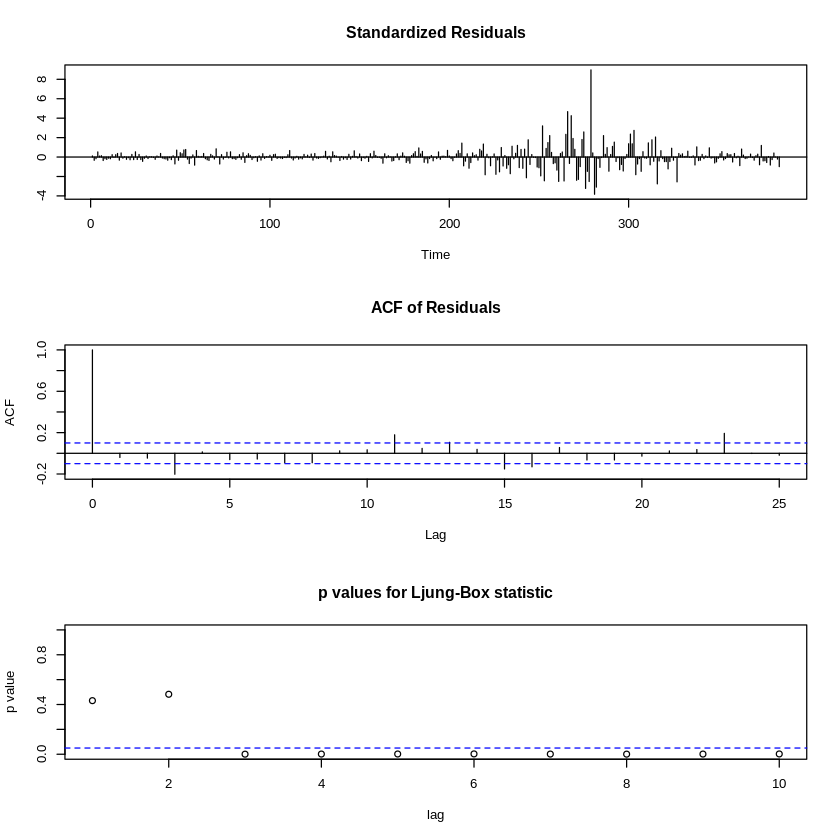

In [143]:
model6 <- arima(window(HomePrice), order=c(0,2,2), seasonal=list(order=c(1,0,1),period=12),  method = "ML")
# Print summary
summary(model6)

# Coefficient test
coeftest(model6)

# Print diagnostics
tsdiag(model6)

## Model Selection

Model | Variance | Log Likelihood | AIC | RMSE
--- | --- | --- | --- | ---
1 | 0.1703 | -203.9 | 409.79 | 0.4115899
2 | 0.1101 | -120.87 | 247.73 | 0.3309369
3 | 0.1166 | -131.82 | 269.64 | 0.3406494
4 | 0.07037 | -40.53 | 87.07 | 0.2646128
5 | 0.09245 | -90.1 | 186.19 | 0.30329
6 | 0.06503 | -25.19 | 60.39 | 0.2543877

Comparing the non-seasonal models, we can see that model2, ARIMA(0,2,2) is the best model.

However, if we take seasonality into account, we can see that model6, ARIMA(0,2,2)(1,0,1)12, stands out as the best model for the forecast.

## Forecasting with Model6

Using model6, we will attempt to forecast the last 24 periods of the timeseries.

First, we will split the data into training set and testing set. The testing set will have the actual price index of the last 24 period and the training set will have all the remaining data.

Then, we will train the ARIMA model with the training set and create a prediction with n.ahead = 24. We will plot out the predicted results compared to the actual results using ggplot, together with 2 * SE as the upper and lower bounds of the prediction.

Finally, we will assess the fit by calculating the RSME and MAE of the actual value vs predicted value. 

Don't know how to automatically pick scale for object of type ts. Defaulting to continuous.


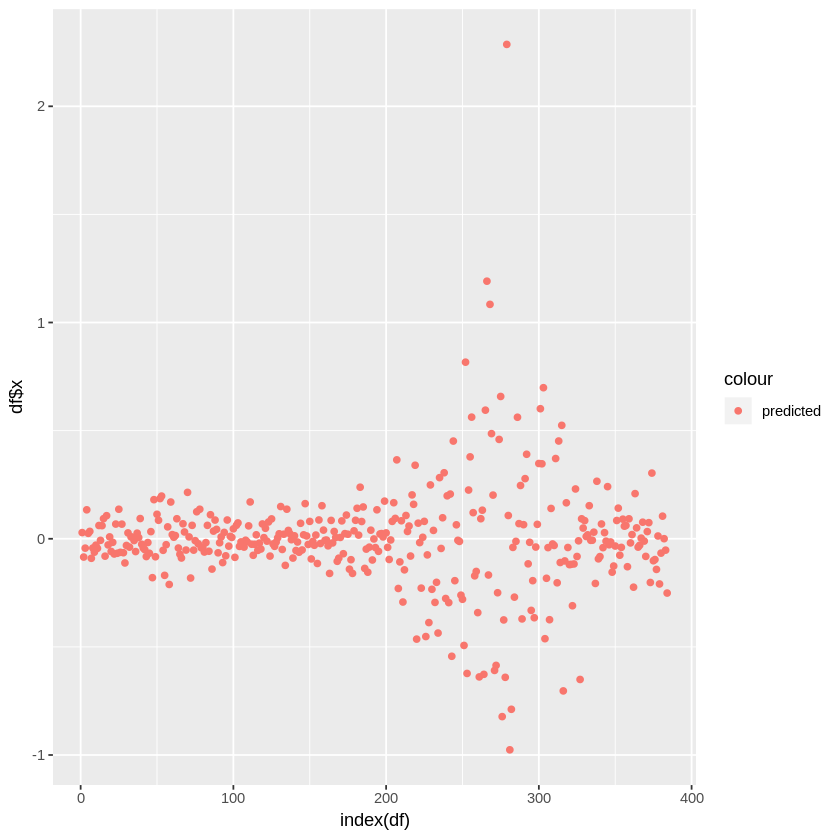

In [146]:
# From the residual plot, we can see that the model starts to diverge at around period 200
# We will forecast ahead for 24 periods to ensure that we do not forecast too far into the future
df = as.data.frame(model6$residuals)
ggplot(df, aes(index(df))) + 
    geom_point(aes(y = df$x, color="predicted"))

In [147]:
periodToForecast = 24
trainPeriod = nrow(HomePrice)-periodToForecast

# Split data into training set
train = HomePrice[1:trainPeriod]

# Create new model with training set
fit = arima(train, order=c(0,2,2), seasonal=list(order=c(1,0,1),period=12),  method = "ML")

# Create prediction
predictions = predict(fit,n.ahead=periodToForecast,se.fit=TRUE)

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.


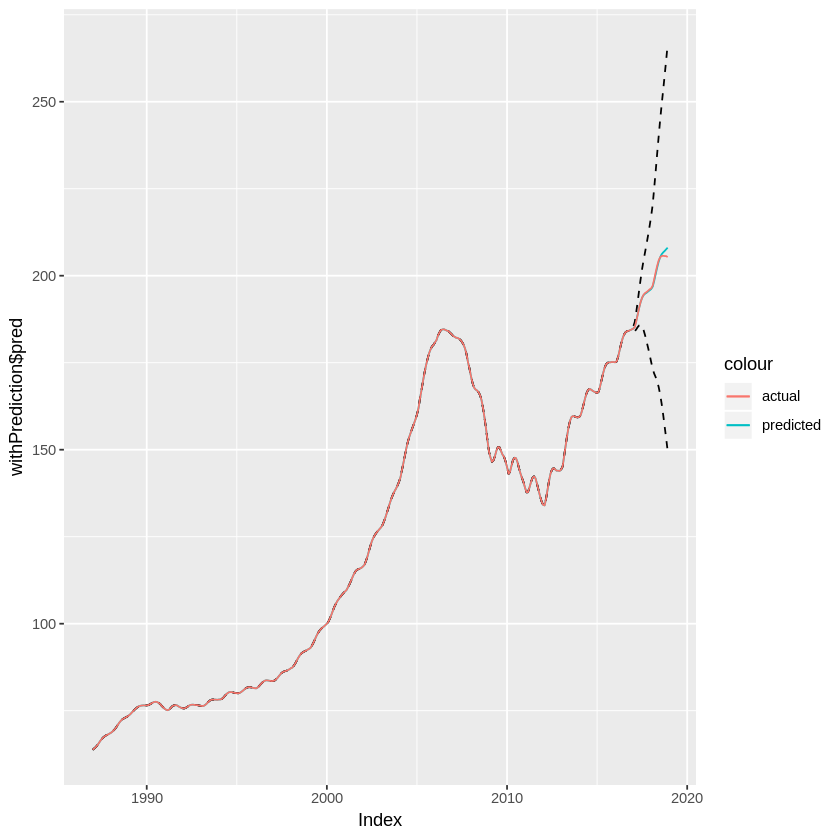

In [148]:
# Create dataframe of HomePrice with prediction and 2 * SE bounds
pred = c()
upper = c()
lower = c()
for(i in 1:nrow(HomePrice)){
    if(i <= nrow(HomePrice) - periodToForecast){
        pred[i] = HomePrice$CSUSHPINSA[i]
        upper[i] = HomePrice$CSUSHPINSA[i]
        lower[i] = HomePrice$CSUSHPINSA[i]
    }else{
        p = i - trainPeriod
        pred[i] = predictions$pred[p]
        upper[i] = predictions$pred[p] + 2*predictions$se[p]
        lower[i] = predictions$pred[p] - 2*predictions$se[p]
    }
}
withPrediction = merge(HomePrice, pred, upper, lower)

ggplot(withPrediction, aes(Index)) + 
    geom_line(aes(y = withPrediction$pred, color="predicted")) +
    geom_line(aes(y = withPrediction$upper), linetype="dashed") +
    geom_line(aes(y = withPrediction$lower), , linetype="dashed") +
    geom_line(aes(y = withPrediction$CSUSHPINSA, color="actual"))

In [149]:
library(DescTools)

rmseM4 = RMSE(withPrediction[-24]$pred, withPrediction[-24]$CSUSHPINSA)
maeM4 = MAE(withPrediction[-24]$pred, withPrediction[-24]$CSUSHPINSA)

sprintf("RSME: %s", rmseM4)
sprintf("MAE: %s", maeM4)

[1] "RSME: 0.20343626321072"

[1] "MAE: 0.0301369453065544"

## Forecasting with Model2

For comparison, we will also generate a forecast using model2, the best model for non-seasonal ARIMA, using the same methodology as above. 

In [150]:
periodToForecast = 24
trainPeriod = nrow(HomePrice)-periodToForecast

# Split data into training set
train = HomePrice[1:trainPeriod]

# Create new model with training set
fit = arima(train, order=c(0,2,2),  method = "ML")

# Create prediction
predictions = predict(fit,n.ahead=periodToForecast,se.fit=TRUE)

Don't know how to automatically pick scale for object of type xts/zoo. Defaulting to continuous.


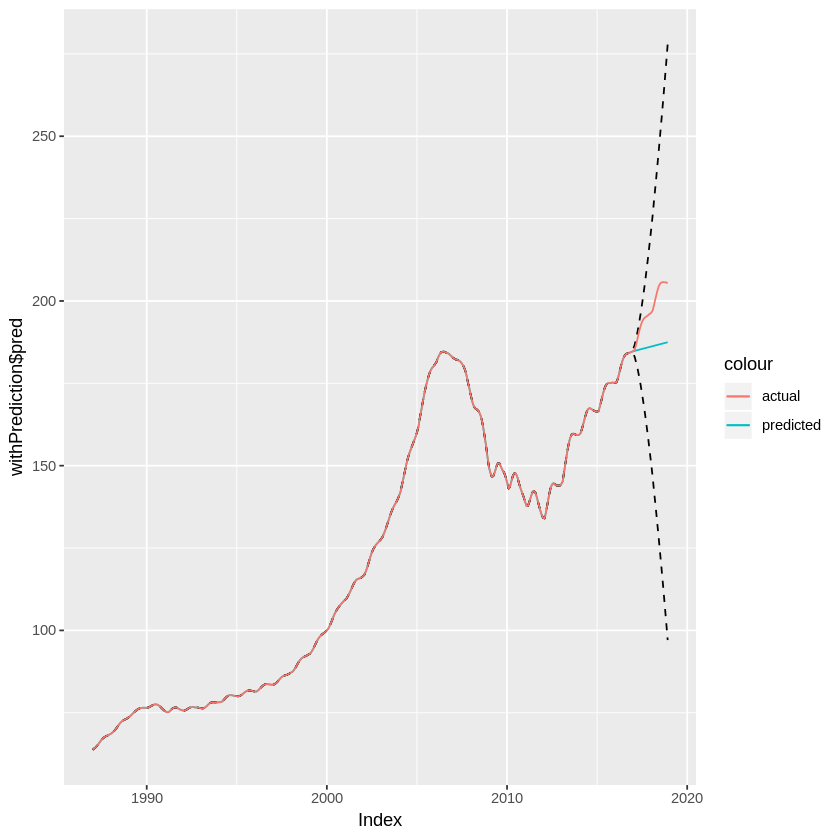

In [151]:
# Create dataframe of HomePrice with prediction and 2 * SE bounds
pred = c()
upper = c()
lower = c()
for(i in 1:nrow(HomePrice)){
    if(i <= nrow(HomePrice) - periodToForecast){
        pred[i] = HomePrice$CSUSHPINSA[i]
        upper[i] = HomePrice$CSUSHPINSA[i]
        lower[i] = HomePrice$CSUSHPINSA[i]
    }else{
        p = i - trainPeriod
        pred[i] = predictions$pred[p]
        upper[i] = predictions$pred[p] + 2*predictions$se[p]
        lower[i] = predictions$pred[p] - 2*predictions$se[p]
    }
}
withPrediction = merge(HomePrice, pred, upper, lower)

ggplot(withPrediction, aes(Index)) + 
    geom_line(aes(y = withPrediction$pred, color="predicted")) +
    geom_line(aes(y = withPrediction$upper), linetype="dashed") +
    geom_line(aes(y = withPrediction$lower), , linetype="dashed") +
    geom_line(aes(y = withPrediction$CSUSHPINSA, color="actual"))

In [152]:
library(DescTools)

rmseM4 = RMSE(withPrediction[-24]$pred, withPrediction[-24]$CSUSHPINSA)
maeM4 = MAE(withPrediction[-24]$pred, withPrediction[-24]$CSUSHPINSA)

sprintf("RSME: %s", rmseM4)
sprintf("MAE: %s", maeM4)

[1] "RSME: 3.15135963408827"

[1] "MAE: 0.695226491205824"

##  Conclusion

The selected non-seasonal ARIMA model is (0,2,2) where p = 0, d = 2 & q = 2. However, the model does not fully explain the seasonal nature of the time series data.

From seasonal models, we can see that model6 outperforms model2 significantly through visual confirmations, as well as comparing the RSME (0.203 vs 3.15).

The selected seasonal ARIMA model is (0,2,2)(1,0,1)12 where:

- p = 0
- d = 2
- q = 2
- P = 1
- D = 0
- Q = 1
- n = 12


## Improving the forecasts

Prices are affected by supply and demand. Thus, supply-
side factors could include number of houses and interest rates (i.e. ease of getting a
mortgage). Demand-side factors could be population, wages, and inflation. GDP may be a
factor that influences both supply and demand.